In [ ]:
import pandas as pd

import pandas as pd
import numpy as np
import timm
import torchvision.transforms as T
import torch

from wildlife_tools.features import DeepFeatures
from wildlife_tools.data import ImageDataset


In [3]:


# Load metadata
PT_CSV = '/Users/ash/phd/guppies/coding/wildlife-tools/exploring/top_10_individuals.csv'
PT_images = '/Users/ash/phd/guppies/data/test_imgs_blacked'
df = pd.read_csv(PT_CSV)
# df['path'] = df['path'].str.replace('.JPG', '.png', case=False)
# df.to_csv(PT_CSV, index=False)
df.head()

,identity,path,date
0,63498,1706/Lower Lalaja/29A/DCIM/121D7100/DSC_8870.png,2017-06-29
1,63498,1803/LL/26B/123D7100/DSC_3857.png,2018-03-26
2,63498,1804/LL/27B/DSC_5389.png,2018-04-27
3,63498,1802/LL/26B/DSC_0428.png,2018-02-26
4,63498,1806/LL/28A/100D7100/DSC_9352.png,2018-06-28


In [4]:

# Define image transformations
transform = T.Compose([
    T.Resize((224, 224)),  # Resize to match MegaDescriptor-L-384 input
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the dataset
dataset = ImageDataset(df, root=PT_images, transform=transform)


In [6]:


# Load the MegaDescriptor model
# model = timm.create_model('hf-hub:BVRA/MegaDescriptor-L-384', pretrained=True, num_classes=0)
model = timm.create_model('hf-hub:BVRA/MegaDescriptor-T-224', pretrained=True, num_classes=0)
extractor = DeepFeatures(model)

# Extract features
features = extractor(dataset)


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.95s/it]


In [7]:
assert len(features) == len(dataset)
assert tuple(features.features.shape) == (len(dataset), 768)

In [8]:
# Convert embeddings to NumPy array
embeddings = features.features
if isinstance(embeddings, torch.Tensor):
    embeddings = embeddings.detach().cpu().numpy()

# Extract labels
labels = features.labels_string  # Assuming labels are stored here

In [9]:
print(labels[:10])  # Print first 10 labels for verification
print(len(set(labels))) #number of individuals
print(embeddings.shape)

['63498' '63498' '63498' '63498' '63498' '63498' '63498' '63498' '63498'
 '63498']
10
(304, 768)


In [13]:
from sklearn.manifold import TSNE

# Determine the number of samples
n_samples = embeddings.shape[0]

# Set perplexity to a value less than n_samples
perplexity_value = min(5, n_samples - 1)

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(embeddings)


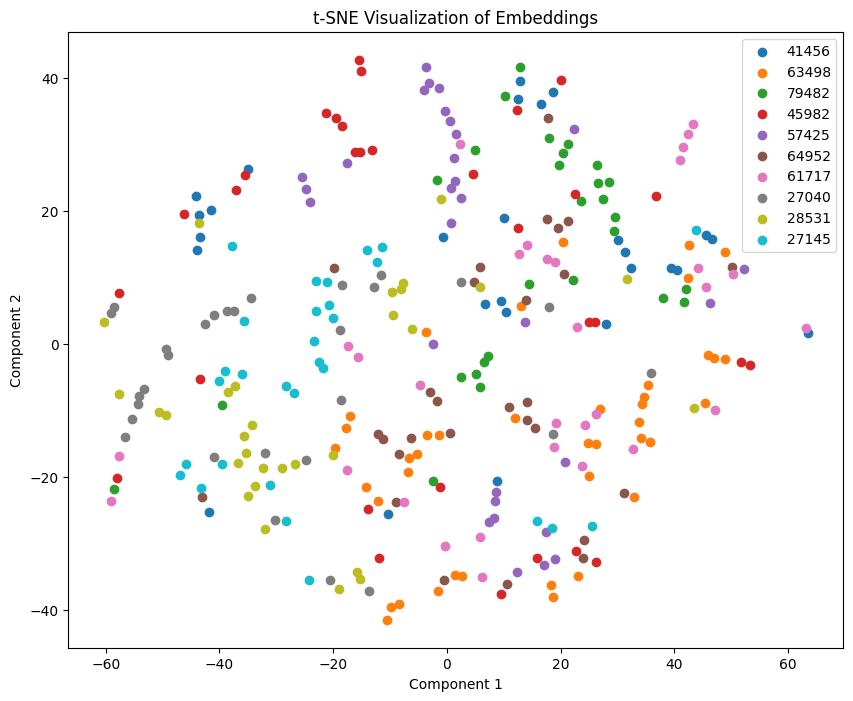

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
unique_labels = set(labels)
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label)

plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [15]:
from wildlife_tools.similarity import CosineSimilarity
from wildlife_tools.inference import KnnClassifier
import numpy as np

# Split dataset into query and database sets
query_df = df.sample(frac=0.2, random_state=42)
database_df = df.drop(query_df.index)

# Create ImageDataset instances
query_dataset = ImageDataset(query_df, root=PT_images, transform=transform)
database_dataset = ImageDataset(database_df, root=PT_images, transform=transform)

# Extract features
query_features = extractor(query_dataset)
database_features = extractor(database_dataset)

# Compute cosine similarity
similarity_function = CosineSimilarity()
similarity = similarity_function(query_features, database_features)

# Perform 1-NN classification
classifier = KnnClassifier(k=1, database_labels=database_dataset.labels_string)
predictions = classifier(similarity)

# Evaluate accuracy
accuracy = np.mean(np.array(query_dataset.labels_string) == np.array(predictions))
print(f'1-NN Classification Accuracy: {accuracy:.2%}')


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.56s/it]

1-NN Classification Accuracy: 42.62%


In [16]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings)
# Initialize dictionaries to hold similarities
same_identity_sims = defaultdict(list)
different_identity_sims = defaultdict(list)

num_embeddings = len(embeddings)

for i in range(num_embeddings):
    for j in range(i + 1, num_embeddings):
        sim = similarity_matrix[i][j]
        if labels[i] == labels[j]:
            same_identity_sims[labels[i]].append(sim)
        else:
            key = f"{labels[i]} vs {labels[j]}"
            different_identity_sims[key].append(sim)

# Compute average similarities
avg_same_identity_sim = np.mean([np.mean(sims) for sims in same_identity_sims.values()])
avg_different_identity_sim = np.mean([np.mean(sims) for sims in different_identity_sims.values()])

print(f"Average similarity within the same identity: {avg_same_identity_sim:.4f}")
print(f"Average similarity between different identities: {avg_different_identity_sim:.4f}")

Average similarity within the same identity: 0.7211
Average similarity between different identities: 0.6846


In [17]:
print(same_identity_sims.values())
print(different_identity_sims.values())

dict_values([[np.float32(0.5897577), np.float32(0.58889264), np.float32(0.69689214), np.float32(0.7657286), np.float32(0.6259165), np.float32(0.5591923), np.float32(0.75135314), np.float32(0.79707706), np.float32(0.7054736), np.float32(0.726728), np.float32(0.6986244), np.float32(0.63735974), np.float32(0.69661677), np.float32(0.712102), np.float32(0.8337697), np.float32(0.8229741), np.float32(0.6431275), np.float32(0.51261014), np.float32(0.643379), np.float32(0.6739161), np.float32(0.7673507), np.float32(0.6809308), np.float32(0.625531), np.float32(0.54354525), np.float32(0.6464174), np.float32(0.6839471), np.float32(0.62838185), np.float32(0.84229755), np.float32(0.6540809), np.float32(0.6915246), np.float32(0.6609468), np.float32(0.7585701), np.float32(0.81333643), np.float32(0.62600666), np.float32(0.6801876), np.float32(0.7674482), np.float32(0.65084624), np.float32(0.7107615), np.float32(0.8168498), np.float32(0.6716592), np.float32(0.8249768), np.float32(0.8140458), np.float32(

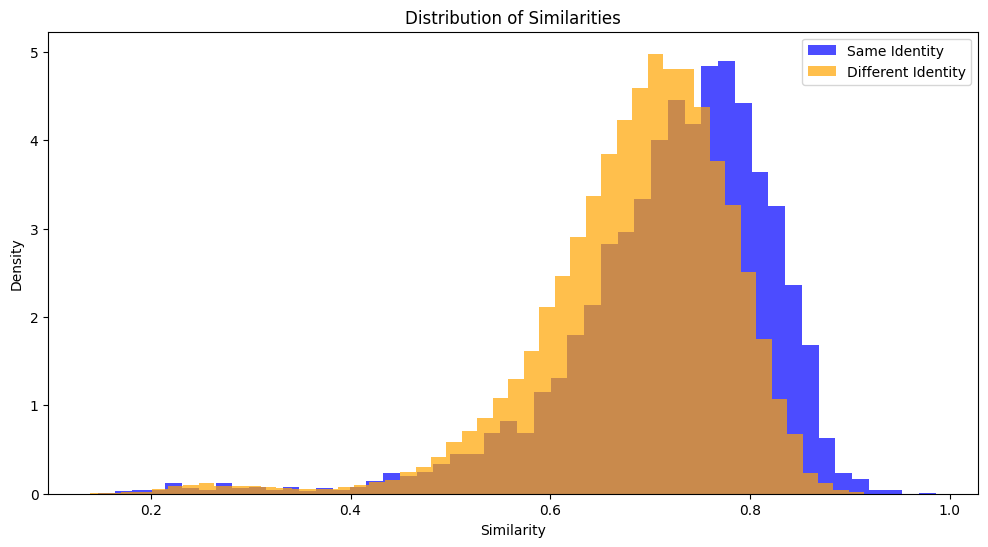

In [18]:
plt.figure(figsize=(12, 6))

# Flatten the lists of similarities
same_identity_flat = [sim for sims in same_identity_sims.values() for sim in sims]
different_identity_flat = [sim for sims in different_identity_sims.values() for sim in sims]

# Plot histograms
plt.hist(same_identity_flat, bins=50, alpha=0.7, label='Same Identity', color='blue', density=True)
plt.hist(different_identity_flat, bins=50, alpha=0.7, label='Different Identity', color='orange', density=True)

# Add labels and legend
plt.title('Distribution of Similarities')
plt.xlabel('Similarity')
plt.ylabel('Density')
plt.legend()

plt.show()